In [3]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [4]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [5]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [6]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [7]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [8]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [9]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    rows[0] = 0
    cols[0] = 0
    if ncv > 1:
        data[1] = coeffs.aE[0]
        rows[1] = 0
        cols[1] = 1

    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
        
    if ncv > 1:
        data[3*ncv-4] = coeffs.aW[-1]
        data[3*ncv-3] = coeffs.aP[-1]
        rows[3*ncv-4:3*ncv-2] = ncv-1
        cols[3*ncv-4] = ncv-2
        cols[3*ncv-3] = ncv-1
        
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

## Problem 1:

In [10]:
#Problem 1
# For ncv 1
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 1
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T1 = T
    xP1 = grid.xP

Iteration = 0; Max. Resid. = 2.9999999999999996; Avg. Resid. = 2.9999999999999996
[373. 323. 273.]
Iteration = 1; Max. Resid. = 0.0; Avg. Resid. = 0.0


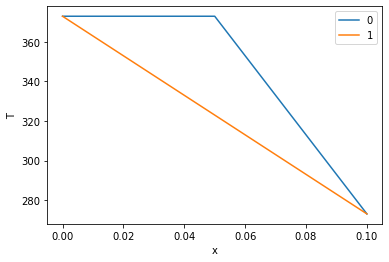

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [12]:
#Problem 1
#Grid 2
# For ncv 2
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 2
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T2 = T
    xP2 = grid.xP

Iteration = 0; Max. Resid. = 6.000000000000001; Avg. Resid. = 3.0000000000000004
[373. 348. 298. 273.]
Iteration = 1; Max. Resid. = 6.661338147750939e-16; Avg. Resid. = 4.440892098500626e-16


In [13]:
#Problem 1
#Grid 3
# For ncv 4
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T3 = T
    xP3 = grid.xP

Iteration = 0; Max. Resid. = 12.000000000000002; Avg. Resid. = 3.0000000000000004
[373.  360.5 335.5 310.5 285.5 273. ]
Iteration = 1; Max. Resid. = 6.661338147750939e-16; Avg. Resid. = 5.551115123125783e-16


In [14]:
#Problem 1
#Grid 4
# For ncv 8
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T4 = T
    xP4 = grid.xP

Iteration = 0; Max. Resid. = 23.99999999999998; Avg. Resid. = 2.9999999999999973
[373.   366.75 354.25 341.75 329.25 316.75 304.25 291.75 279.25 273.  ]
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


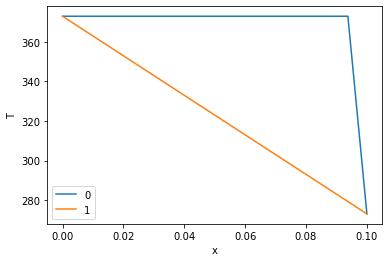

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

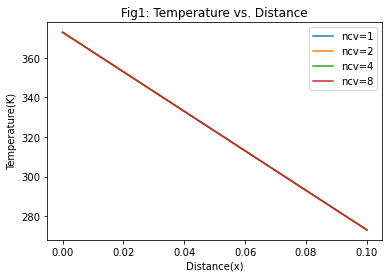

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xP1, T1, label='ncv=1')
plt.plot(xP2, T2, label='ncv=2')
plt.plot(xP3, T3, label='ncv=4')
plt.plot(xP4, T4, label='ncv=8')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
#Display the title
plt.title('Fig1: Temperature vs. Distance')
plt.show()


# Linear Heat Conduction
## Explanation of Result:

The Steady state heat conduction with heat generation (d/dt = 0 and egen = 0) is 
                      $$  d^2T/dx^2 = 0 $$
After Integrating twice, the temperature profile becomes:
                    $$    T = ax + b $$
                
where a and b are arbitary constants.
                
As the equation of T is a linear, the temperature profile shown in Figure1 is also linear.
For 273K temperature at the west boundary and 373K temperature at the east boundary,
the temperature profile varies from 373 to 273.

## Grid Independence Test:

In figure1, the temperature profile has been printed for number of control volume(ncv) 1,2,4 and 8.
It is visible from the graph that problem converges even for 1 ncv for a thermal conduction problem
with no heat generation. The problem converges only after one iteration as it is a liner profile temperature problem.




In [17]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
      
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    

# Problem 2

In [18]:
# Problem 2
# Grid Independence Study
# Grid 1 for ncv 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

#Calculating the minimum temperature for Grid Indepedence test:
avg1 = np.mean(T)
print('Average Temp for ncv = 4 is ', avg1)

#Saving the solution for grid indepence test   
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 0.45; Avg. Resid. = 0.45
[373.         366.46473029 360.2406639  360.2406639  366.46473029
 373.        ]
Iteration = 1; Max. Resid. = 1.27675647831893e-15; Avg. Resid. = 1.0269562977782698e-15
Average Temp for ncv = 4 is  366.5684647302904


In [19]:
# Problem 2 
#Grid 2 for ncv 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

#Calculating the avg temperature for Grid Indepedence test:
avg2 = np.mean(T)
print('Average Temp for ncv = 8 is ', avg2)    
    
#Storing the solution for grid independence test   
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 0.225; Avg. Resid. = 0.225
[373.         369.69413636 364.8747625  361.7272577  360.17293434
 360.17293434 361.7272577  364.8747625  369.69413636 373.        ]
Iteration = 1; Max. Resid. = 1.1324274851176597e-14; Avg. Resid. = 4.107825191113079e-15
Average Temp for ncv = 8 is  365.8938181807584


In [20]:
# Problem 2
# Grid 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg3 = np.mean(T)
print('Average Temp for ncv = 16 is ', avg3)


#Storing the solution fo grid indepence test
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 0.1125; Avg. Resid. = 0.1125
[373.         371.34220263 368.48499666 366.06832192 364.07707419
 362.49880818 361.32365972 360.54428413 360.15581031 360.15581031
 360.54428413 361.32365972 362.49880818 364.07707419 366.06832192
 368.48499666 371.34220263 373.        ]
Iteration = 1; Max. Resid. = 1.3655743202889425e-14; Avg. Resid. = 7.232062171347309e-15
Average Temp for ncv = 16 is  365.27723974926914


In [21]:
# Problem 2
# Grid 4 for ncv = 32
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg4 = np.mean(T)
print('Average Temp for ncv = 32 is ', avg4)
    
#Storing the solution for grid indepence test
T4 = T
xP4 = grid.xP

Iteration = 0; Max. Resid. = 0.05625; Avg. Resid. = 0.05625
[373.         372.17049035 370.62736244 369.19771478 367.87931355
 366.67009875 365.56818098 364.57183849 363.6795145  362.88981475
 362.20150533 361.61351077 361.12491232 360.73494654 360.44300412
 360.24862889 360.15151715 360.15151715 360.24862889 360.44300412
 360.73494654 361.12491232 361.61351077 362.20150533 362.88981475
 363.6795145  364.57183849 365.56818098 366.67009875 367.87931355
 369.19771478 370.62736244 372.17049035 373.        ]
Iteration = 1; Max. Resid. = 4.020395127923848e-14; Avg. Resid. = 1.778568611832121e-14
Average Temp for ncv = 32 is  364.8689619833984


In [22]:
# Problem 2
# Grid 5 for ncv = 64
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg5 = np.mean(T)
print('Average Temp for ncv = 64 is ', avg5)
    
#Storing the solution for grid indepence test
T5 = T
xP5 = grid.xP

Iteration = 0; Max. Resid. = 0.028125; Avg. Resid. = 0.028125000000000004
Iteration = 1; Max. Resid. = 1.0437831154952448e-13; Avg. Resid. = 2.869080840961491e-14
Average Temp for ncv = 64 is  364.6344294739056


In [23]:
# Problem 2
# Grid 6 for ncv = 84
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 84
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg6 = np.mean(T)
print('Average Temp for ncv = 84 is ', avg6)
    
#Storing the solution for grid indepence test
T6 = T
xP6 = grid.xP

Iteration = 0; Max. Resid. = 0.02142857142857143; Avg. Resid. = 0.02142857142857143
Iteration = 1; Max. Resid. = 9.794942634755444e-14; Avg. Resid. = 3.889576326365245e-14
Average Temp for ncv = 84 is  364.57530445508144


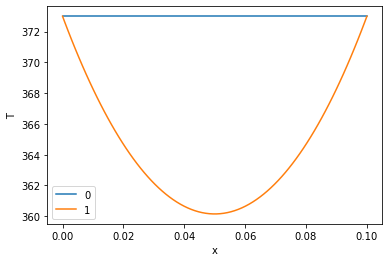

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()


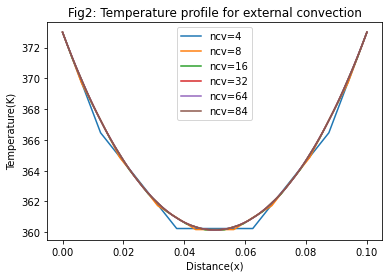

+-----+---------------------+----------------------+
| ncv | Average Temperature |  Difference in Temp  |
+-----+---------------------+----------------------+
|  4  |  366.5684647302904  |  366.5684647302904   |
|  8  |  365.8938181807584  |  0.6746465495319853  |
|  16 |  365.27723974926914 |  0.6165784314892448  |
|  32 |  364.8689619833984  | 0.40827776587076414  |
|  64 |  364.6344294739056  | 0.23453250949279436  |
|  84 |  364.57530445508144 | 0.059125018824147446 |
+-----+---------------------+----------------------+


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')
plt.plot(xP4, T4, label='ncv=32')
plt.plot(xP5, T5, label='ncv=64')
plt.plot(xP6, T6, label='ncv=84')

plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig2: Temperature profile for external convection')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Average Temperature", "Difference in Temp"]

x.add_row([4, avg1, avg1])
x.add_row([8, avg2, -avg2+avg1])
x.add_row([16, avg3, -avg3+avg2])
x.add_row([32, avg4, -avg4+avg3])
x.add_row([64, avg5, -avg5+avg4])
x.add_row([84, avg6, -avg6+avg5])

print(x)

# Grid Independence test

Figure 2 shows the different curves for ncv 4,8,16,32 and 64. 
The table above shows the difference in temperature from its previous ncv.
It can noted that the differnce is relatively lower for ncv 32,64 and 84.
For this problem ncv 64 can be selected as an appropriate grid.


Average Temperature from the analytical solution is  364.47394121892177
Average Temperature from the Numerical Solution is 364.6344294739056


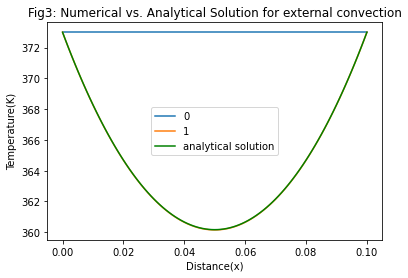

In [26]:
##Comparison between the analytial and numerical solution
%matplotlib inline
import matplotlib.pyplot as plt
import math
#Comparison between analytical and numerical solution
#Numerical Solution
i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
#Analytical Solution
'''
m = sqrt(hp/kA)
h = convection coefficient = 12
k = thermal conductivity = 60
P = perimeter
Ac = Crosssectional Area
'''
m = 12.64 
L = 0.1
# 100 linearly spaced numbers
x = np.arange(0,0.101,.001)
#
R = ((1*(np.sinh(m*x))) + np.sinh(m*(L-x))) * (75 / np.sinh(m*L))
P = R + 298

#Display the avg temp for analytical solution
Avg_temp = np.mean(P)
print("Average Temperature from the analytical solution is ", Avg_temp)
#Display the avg temp for the numerical solution
print("Average Temperature from the Numerical Solution is", avg5)
plt.plot(x,P, 'g', label='analytical solution')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
plt.title("Fig3: Numerical vs. Analytical Solution for external convection")
plt.show()



## Comparison between the analytial and numerical solution

Figure 3 shows the curves for both analytical and numerical solution.



# Problem 3 :

In [27]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
            k.......thermal conductivity
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [28]:
class HeatGenerationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, q):
        """Constructor"""
        self._grid = grid

        self._q = q #heat generated per volume
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculating the source term SpVp with a negative sign to subtract it.
        source =  - self._q*self._grid.vol
        #print(source)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [29]:
#problem 3
#Grid 1 for ncv = 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 4

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 320

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
min1 = np.min(T)
print('Minimum Temp for ncv = 4 is ', min1)
    
#Storing the solution for grid indepence test
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 1990.3389830508695; Avg. Resid. = 1241.9491525423814
[328.67857143 329.44299451 329.76991758 328.89491758 326.81799451
 325.17857143]
Iteration = 1; Max. Resid. = 7.73070496506989e-11; Avg. Resid. = 3.8767211663071066e-11
Minimum Temp for ncv = 4 is  325.1785714285714


In [30]:
#problem 3
#Grid 2 for ncv = 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 8

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 320

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
min2 = np.min(T)
print('Minimum Temp for ncv = 8 is ', min2)
    
#Storing the solution for grid indepence test
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 1412.0270270271612; Avg. Resid. = 796.6779279279147
[328.67857143 329.06078297 329.52472527 329.68818681 329.55116758
 329.11366758 328.37568681 327.33722527 325.99828297 325.17857143]
Iteration = 1; Max. Resid. = 1.2710188457276672e-10; Avg. Resid. = 8.931522188504459e-11
Minimum Temp for ncv = 8 is  325.1785714285722


In [31]:
#problem 3
#Grid 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 16

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 320

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added RobinBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the Heat Generation model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
min3 = np.min(T)
print('Minimum Temp for ncv = 16 is ', min3)
    
#Storing the solution for grid indepence test
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 1583.6860465115735; Avg. Resid. = 442.7398255813863
[328.67857143 328.8696772  329.17676854 329.4087397  329.56559066
 329.64732143 329.65393201 329.58542239 329.44179258 329.22304258
 328.92917239 328.56018201 328.11607143 327.59684066 327.0024897
 326.33301854 325.5884272  325.17857143]
Iteration = 1; Max. Resid. = 2.9058355721645057e-10; Avg. Resid. = 1.0900436109295697e-10
Minimum Temp for ncv = 16 is  325.1785714285714


In [32]:
#problem 3
#Grid 4 for ncv = 32
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 32

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 320

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
min4 = np.min(T)
print('Minimum Temp for ncv = 32 is ', min4)
    
#Storing the solution for grid indepence test
T4 = T
xP4 = grid.xP

Iteration = 0; Max. Resid. = 1771.3150118197586; Avg. Resid. = 232.53638445623915
Iteration = 1; Max. Resid. = 8.008100849110633e-10; Avg. Resid. = 2.729052539507393e-10
Minimum Temp for ncv = 32 is  325.17857142857235


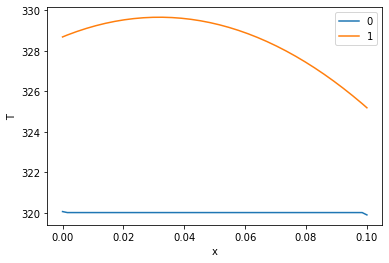

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

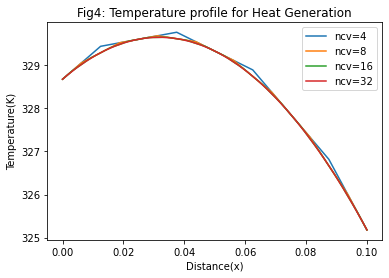

+-----+---------------------+------------------------+
| ncv | Minimun Temperature |   Difference in Temp   |
+-----+---------------------+------------------------+
|  4  |  325.1785714285714  |   325.1785714285714    |
|  8  |  325.1785714285722  | -7.958078640513122e-13 |
|  16 |  325.1785714285714  | 7.958078640513122e-13  |
|  32 |  325.17857142857235 | -9.663381206337363e-13 |
+-----+---------------------+------------------------+


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')
plt.plot(xP4, T4, label='ncv=32')


plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig4: Temperature profile for Heat Generation')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Minimun Temperature", "Difference in Temp"]

x.add_row([4, min1, min1])
x.add_row([8, min2, -min2+min1])
x.add_row([16, min3, -min3+min2])
x.add_row([32, min4, -min4+min3])


print(x)

# Grid Independence Test:

Figure 4 displays the different curves generated for ncv 4,8, 16, and 32. From the table above, it can be seen that the difference between the minimum temperature is extremely low. The results are not affected much for coarse to fine grid.
For this problem, the results generated for ncv=16 are used to compare with the analytical solution.

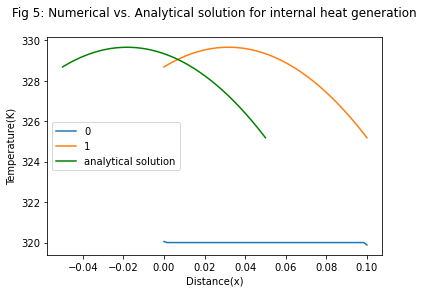

Minimum Temperature from analytical solution is: 325.17857142857144
Minimum Temperature from numerical solution is: 325.1785714285714


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

#Numerical Sotuion
i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

#Analytical solution
T1 = 323
T2 = 313
L = 0.05
x = np.arange(-0.05, 0.051, .001)

P = ((12500/13)*(L**2 - x**2)) + ((T2-T1)*x*(7/2)) + (T1+T2)/2 + (125/14)
#print(P)
#x = np.arange(0, 0.1, .001)
plt.plot(x, P, 'g', label = 'analytical solution')    
minP = np.min(P)


plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
plt.title('Fig 5: Numerical vs. Analytical solution for internal heat generation\n')
plt.show()

#Display the minimum temp for both analytical and numerical solution
print('Minimum Temperature from analytical solution is:' , minP)
print('Minimum Temperature from numerical solution is:' , min3)

# Conclusion from Result: 


# Problem 4: Explicit Implementation for Steel

In [36]:
# Problem 4
# Surface Radiation model for Explicit Implementation
class SurfaceRadiationModel:
    """Class defining a surface Radiation model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface radiation terms to coefficient arrays"""
        
        # Calculate the source term
        source = -self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)*self._grid.Ao
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [42]:
#Problem 4 for steel
#Grid 1 for ncv = 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60         #Thermal Conductivity of steel

# Define convection parameters
h = 0
epi = 1                  #emmisivity
sigma = 5.67e-8          #Stefan-Boltzmann constant
Tc = 0                   

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
# The temperature at east and west boundary is fixed to 400K and 0K.
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface radiation model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg1 = np.mean(T)
print('Average Temp for ncv = 4 is ', avg1)

#Saving the solution for grid indepence test   
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 35.770365000000005; Avg. Resid. = 12.114817500000001
Iteration = 1; Max. Resid. = 0.22939700828782525; Avg. Resid. = 0.1902300976985321
Iteration = 2; Max. Resid. = 0.006135358938732419; Avg. Resid. = 0.00220579416949762
Iteration = 3; Max. Resid. = 0.00020921561100434305; Avg. Resid. = 0.00010410296807006385
Iteration = 4; Max. Resid. = 1.2313802435937049e-05; Avg. Resid. = 5.487052960419616e-06
Iteration = 5; Max. Resid. = 6.903374465405676e-07; Avg. Resid. = 2.8295660413340536e-07
Average Temp for ncv = 4 is  201.98051027913667


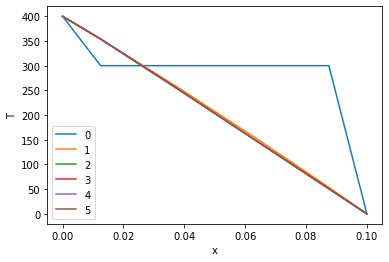

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [44]:
#Problem 4 for steel
#Grid 2 for ncv = 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60         #Thermal Conductivity of steel

# Define convection parameters
h = 0
epi = 1                  #emmisivity
sigma = 5.67e-8          #Stefan-Boltzmann constant
Tc = 0                   

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
# The temperature at east and west boundary is fixed to 400K and 0K.
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface radiation model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg2 = np.mean(T)
print('Average Temp for ncv = 8 is ', avg2)

#Saving the solution for grid indepence test   
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 71.88518249999994; Avg. Resid. = 12.086113124999994
Iteration = 1; Max. Resid. = 0.17126442242140227; Avg. Resid. = 0.09520030197980353
Iteration = 2; Max. Resid. = 0.003124661507890203; Avg. Resid. = 0.0012953012867368784
Iteration = 3; Max. Resid. = 0.00014950214450015764; Avg. Resid. = 5.981087492674359e-05
Iteration = 4; Max. Resid. = 7.446786636305935e-06; Avg. Resid. = 2.7925546581225587e-06
Iteration = 5; Max. Resid. = 3.4339267193650436e-07; Avg. Resid. = 1.2710180559140285e-07
Average Temp for ncv = 8 is  202.04603954992837


In [45]:
#Problem 4 for steel
#Grid 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60         #Thermal Conductivity of steel

# Define convection parameters
h = 0
epi = 1                  #emmisivity
sigma = 5.67e-8          #Stefan-Boltzmann constant
Tc = 0                   

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
# The temperature at east and west boundary is fixed to 400K and 0K.
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface radiation model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg3 = np.mean(T)
print('Average Temp for ncv = 16 is ', avg3)

#Saving the solution for grid indepence test   
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 143.94259124999988; Avg. Resid. = 12.050232656249992
Iteration = 1; Max. Resid. = 0.10397657486232015; Avg. Resid. = 0.047609154900538506
Iteration = 2; Max. Resid. = 0.0015748609821462645; Avg. Resid. = 0.0006447083735734122
Iteration = 3; Max. Resid. = 7.80274193732805e-05; Avg. Resid. = 3.042380971731167e-05
Iteration = 4; Max. Resid. = 3.654467512617665e-06; Avg. Resid. = 1.376900032844616e-06
Iteration = 5; Max. Resid. = 1.6466373634060893e-07; Avg. Resid. = 6.11710114958809e-08
Average Temp for ncv = 16 is  202.17666177540352


In [46]:
#Problem 4 for steel
#Grid 4 for ncv = 32
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60         #Thermal Conductivity of steel

# Define convection parameters
h = 0
epi = 1                  #emmisivity
sigma = 5.67e-8          #Stefan-Boltzmann constant
Tc = 0                   

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
# The temperature at east and west boundary is fixed to 400K and 0K.
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface radiation model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg4 = np.mean(T)
print('Average Temp for ncv = 32 is ', avg4)

#Saving the solution for grid indepence test   
T4 = T
xP4 = grid.xP

Iteration = 0; Max. Resid. = 287.971295625001; Avg. Resid. = 12.026910351562531
Iteration = 1; Max. Resid. = 0.056891873995883094; Avg. Resid. = 0.02380565109237605
Iteration = 2; Max. Resid. = 0.0007921166072736609; Avg. Resid. = 0.0003217284808648865
Iteration = 3; Max. Resid. = 3.9094437959616424e-05; Avg. Resid. = 1.5248446132750365e-05
Iteration = 4; Max. Resid. = 1.8484402764737395e-06; Avg. Resid. = 6.853033631941905e-07
Iteration = 5; Max. Resid. = 8.284186636675628e-08; Avg. Resid. = 3.0281051214903116e-08
Average Temp for ncv = 32 is  202.27879312491515


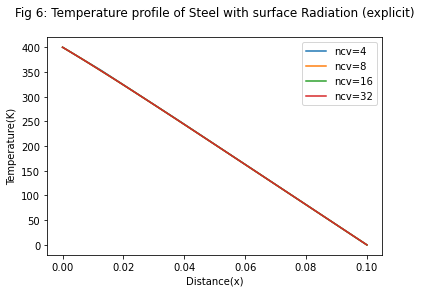

+-----+---------------------+----------------------+
| ncv | Average Temperature |  Difference in Temp  |
+-----+---------------------+----------------------+
|  4  |  201.98051027913667 |  201.98051027913667  |
|  8  |  202.04603954992837 | -0.0655292707916999  |
|  16 |  202.17666177540352 | -0.13062222547515034 |
|  32 |  202.27879312491515 | -0.10213134951163738 |
+-----+---------------------+----------------------+


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')
plt.plot(xP4, T4, label='ncv=32')


plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig 6: Temperature profile of Steel with surface Radiation (explicit)\n')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Average Temperature", "Difference in Temp"]

x.add_row([4, avg1, avg1])
x.add_row([8, avg2, -avg2+avg1])
x.add_row([16, avg3, -avg3+avg2])
x.add_row([32, avg4, -avg4+avg3])


print(x)

## Grid Independence Test (Steel) :

Firgure 6 shows all the linear temparature profile for ncv 4,8,16 and 32. The table above shows that the difference in temprture is very low. The solution converges after 5 iteration.

# Problem 4: Implicit Implementation for Steel

In [50]:
# Problem 4(2)
#Radiation model with implicit implementation 
class SurfaceRadiationModel2:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)*self._grid.Ao
        
        # Calculate the linearization coefficients
        coeffP = self._epi*self._sigma*((self._T[1:-1])**3)*4*self._grid.Ao      #Coefficients for implicit implementation
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [52]:
#Grid test 1 for ncv = 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60 #Thermal Conductivity of Steel

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg1 = np.mean(T)
print('Average Temp for ncv = 4 is ', avg1)

#Saving the solution for grid indepence test   
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 36.22963500000001; Avg. Resid. = 12.114817500000001
Iteration = 1; Max. Resid. = 0.5228847715037326; Avg. Resid. = 0.20714131591288426
Iteration = 2; Max. Resid. = 0.00020032741159371759; Avg. Resid. = 0.00011032037474026942
Iteration = 3; Max. Resid. = 2.4673373066885773e-10; Avg. Resid. = 1.0054072246241334e-10
Average Temp for ncv = 4 is  198.21261228901741


In [56]:
#Grid test 2 for ncv = 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60 #Thermal Conductivity of Steel

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg2 = np.mean(T)
print('Average Temp for ncv = 8 is ', avg2)

#Saving the solution for grid indepence test   
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 72.11481749999994; Avg. Resid. = 12.086113124999994
Iteration = 1; Max. Resid. = 0.3027513060619589; Avg. Resid. = 0.10702427103931929
Iteration = 2; Max. Resid. = 0.00010117604460354451; Avg. Resid. = 4.9177072406084106e-05
Iteration = 3; Max. Resid. = 9.069574258280255e-11; Avg. Resid. = 3.810820513535048e-11
Average Temp for ncv = 8 is  198.13106434102536


In [54]:
#Grid test 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60 #Thermal Conductivity of Steel

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg3 = np.mean(T)
print('Average Temp for ncv = 16 is ', avg3)

#Saving the solution for grid indepence test   
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 144.0574087499999; Avg. Resid. = 12.050232656249992
Iteration = 1; Max. Resid. = 0.16179027038557572; Avg. Resid. = 0.05395608038978887
Iteration = 2; Max. Resid. = 4.9798997654410676e-05; Avg. Resid. = 2.3791724969190098e-05
Iteration = 3; Max. Resid. = 4.32901631208793e-11; Avg. Resid. = 1.7639056633279268e-11
Average Temp for ncv = 16 is  198.00799012050834


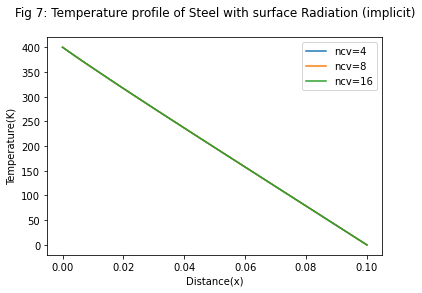

+-----+---------------------+---------------------+
| ncv | Average Temperature |  Difference in Temp |
+-----+---------------------+---------------------+
|  4  |  198.13106434102536 |  198.13106434102536 |
|  8  |  198.13106434102536 |         0.0         |
|  16 |  198.00799012050834 | 0.12307422051702588 |
+-----+---------------------+---------------------+


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')



plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig 7: Temperature profile of Steel with surface Radiation (implicit)\n')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Average Temperature", "Difference in Temp"]

x.add_row([4, avg1, avg1])
x.add_row([8, avg2, -avg2+avg1])
x.add_row([16, avg3, -avg3+avg2])



print(x)

# Grid test for Steel (implicit)

Figure 7 shows all the curves for ncv 4,8 and 16. The difference is not significant. For this implicit method, ncv 32 has been taken for further comparison.

## Conclusion from Result (Steel):

From figure 6 and 7 we can see that the surface radiation problem converges for both implicit and explicit implementation of the source tem. Because the high thermal conductivity of steel (k = 60), the heat transfer does not depened much on the coeffecients. Therefore, the surface radiation problem converges just after 3-5 iterations for methods.


# Problem 4: Surface Radiation for Wood (implicit)

In [59]:
#Problem 4: Implicit implementation for wood
#Grid test 1 for ncv = 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg1 = np.mean(T)
print('Average Temp for ncv = 4 is ', avg1)

#Saving the solution for grid indepence test   
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 0.28963500000000003; Avg. Resid. = 0.23963500000000004
Iteration = 1; Max. Resid. = 0.09785837878849929; Avg. Resid. = 0.07463011645964725
Iteration = 2; Max. Resid. = 0.0339545729044156; Avg. Resid. = 0.022461703210541938
Iteration = 3; Max. Resid. = 0.009851598113408043; Avg. Resid. = 0.006263801729533891
Iteration = 4; Max. Resid. = 0.00280668726094707; Avg. Resid. = 0.0012237134049278414
Iteration = 5; Max. Resid. = 0.0002829609633505706; Avg. Resid. = 0.00010738635144213245
Iteration = 6; Max. Resid. = 2.607200940170113e-06; Avg. Resid. = 1.16590728954211e-06
Iteration = 7; Max. Resid. = 2.8205903628356066e-10; Avg. Resid. = 1.365723447617911e-10
Average Temp for ncv = 4 is  129.09862465519493


In [60]:
#Grid test 2 for ncv = 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg2 = np.mean(T)
print('Average Temp for ncv = 8 is ', avg2)

#Saving the solution for grid indepence test   
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 0.2348174999999999; Avg. Resid. = 0.1248175
Iteration = 1; Max. Resid. = 0.08097147500963871; Avg. Resid. = 0.039031730786746925
Iteration = 2; Max. Resid. = 0.01968667399879814; Avg. Resid. = 0.011434850076550197
Iteration = 3; Max. Resid. = 0.0059241063856393565; Avg. Resid. = 0.0028712837431660735
Iteration = 4; Max. Resid. = 0.001483545889685429; Avg. Resid. = 0.0006053684376672588
Iteration = 5; Max. Resid. = 0.00014585964414503373; Avg. Resid. = 5.349999967838664e-05
Iteration = 6; Max. Resid. = 1.385712031447381e-06; Avg. Resid. = 5.262106587090035e-07
Iteration = 7; Max. Resid. = 1.4884479683941604e-10; Avg. Resid. = 5.192072225660027e-11
Average Temp for ncv = 8 is  116.28385137242878


In [61]:
#Grid test 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg3 = np.mean(T)
print('Average Temp for ncv = 16 is ', avg3)

#Saving the solution for grid indepence test   
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 0.2974087499999998; Avg. Resid. = 0.07023265625
Iteration = 1; Max. Resid. = 0.07615658028097493; Avg. Resid. = 0.02104194384103443
Iteration = 2; Max. Resid. = 0.011468440503638962; Avg. Resid. = 0.005504589395192364
Iteration = 3; Max. Resid. = 0.0031168180018355707; Avg. Resid. = 0.0014339572278227876
Iteration = 4; Max. Resid. = 0.0007712047140298701; Avg. Resid. = 0.0003041920199552021
Iteration = 5; Max. Resid. = 7.263141652288568e-05; Avg. Resid. = 2.6979144264011846e-05
Iteration = 6; Max. Resid. = 7.309070078359179e-07; Avg. Resid. = 2.636284149640438e-07
Average Temp for ncv = 16 is  108.15968189676062


In [65]:
#Grid test 4 for ncv = 32
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg4 = np.mean(T)
print('Average Temp for ncv = 32 is ', avg4)

#Saving the solution for grid indepence test   
T4 = T
xP4 = grid.xP

Iteration = 0; Max. Resid. = 0.5087043750000017; Avg. Resid. = 0.04691035156250005
Iteration = 1; Max. Resid. = 0.0580714584671225; Avg. Resid. = 0.011096722738697419
Iteration = 2; Max. Resid. = 0.0058694829653702105; Avg. Resid. = 0.0027302270898890233
Iteration = 3; Max. Resid. = 0.0015693958630769436; Avg. Resid. = 0.000716099861119499
Iteration = 4; Max. Resid. = 0.00038725720355497746; Avg. Resid. = 0.00015226847420285905
Iteration = 5; Max. Resid. = 3.667870869346588e-05; Avg. Resid. = 1.3513819273930057e-05
Iteration = 6; Max. Resid. = 3.661761882261345e-07; Avg. Resid. = 1.317552867406469e-07
Average Temp for ncv = 32 is  103.47774873945387


In [68]:
#Grid test 5 for ncv = 64
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg5 = np.mean(T)
print('Average Temp for ncv = 64 is ', avg5)

#Saving the solution for grid indepence test   
T5 = T
xP5 = grid.xP

Iteration = 0; Max. Resid. = 0.9743521875000034; Avg. Resid. = 0.03390368164062505
Iteration = 1; Max. Resid. = 0.03572403787533216; Avg. Resid. = 0.005660680715423409
Iteration = 2; Max. Resid. = 0.0029328614049979884; Avg. Resid. = 0.0013622216797239497
Iteration = 3; Max. Resid. = 0.0007880125811453522; Avg. Resid. = 0.00035777446865674795
Iteration = 4; Max. Resid. = 0.00019406315154140983; Avg. Resid. = 7.611599504536689e-05
Iteration = 5; Max. Resid. = 1.832473329387201e-05; Avg. Resid. = 6.7529958830721214e-06
Iteration = 6; Max. Resid. = 1.8241022668776257e-07; Avg. Resid. = 6.57237375100502e-08
Average Temp for ncv = 64 is  100.85591941056789


In [72]:
#Grid test 84 for ncv = 84
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 84
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the average temperature for Grid Indepedence test:
avg6 = np.mean(T)
print('Average Temp for ncv = 84 is ', avg6)

#Saving the solution for grid indepence test   
T6 = T
xP6 = grid.xP

Iteration = 0; Max. Resid. = 1.2709350000000044; Avg. Resid. = 0.03067464285714291
Iteration = 1; Max. Resid. = 0.02852108982584926; Avg. Resid. = 0.0043264625846309804
Iteration = 2; Max. Resid. = 0.0022435438906262214; Avg. Resid. = 0.0010375050665759264
Iteration = 3; Max. Resid. = 0.0005999207912003808; Avg. Resid. = 0.000272553827698579
Iteration = 4; Max. Resid. = 0.00014787329184296464; Avg. Resid. = 5.798923484615596e-05
Iteration = 5; Max. Resid. = 1.3962158463802904e-05; Avg. Resid. = 5.144347309489616e-06
Iteration = 6; Max. Resid. = 1.3900348669174302e-07; Avg. Resid. = 5.005070324953744e-08
Average Temp for ncv = 84 is  100.18666766695327


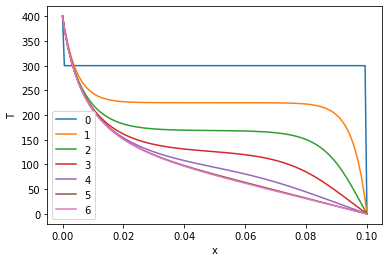

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
plt.show()

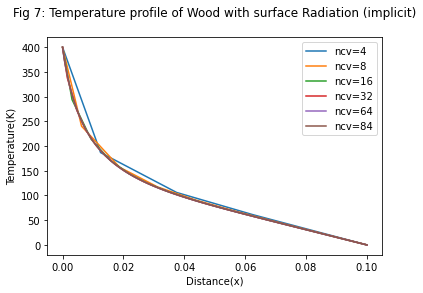

+-----+---------------------+--------------------+
| ncv | Average Temperature | Difference in Temp |
+-----+---------------------+--------------------+
|  4  |  129.09862465519493 | 129.09862465519493 |
|  8  |  116.28385137242878 | 12.81477328276614  |
|  16 |  108.15968189676062 | 8.124169475668168  |
|  32 |  103.47774873945387 | 4.681933157306744  |
|  64 |  100.85591941056789 | 2.6218293288859797 |
|  84 |  100.18666766695327 | 0.6692517436146233 |
+-----+---------------------+--------------------+


In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')
plt.plot(xP4, T4, label='ncv=32')
plt.plot(xP5, T5, label='ncv=64')
plt.plot(xP6, T6, label='ncv=84')


plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig 7: Temperature profile of Wood with surface Radiation (implicit)\n')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Average Temperature", "Difference in Temp"]

x.add_row([4, avg1, avg1])
x.add_row([8, avg2, -avg2+avg1])
x.add_row([16, avg3, -avg3+avg2])
x.add_row([32, avg4, -avg4+avg3])
x.add_row([64, avg5, -avg5+avg4])
x.add_row([84, avg6, -avg6+avg5])

print(x)

# Grid Independence test (Wood) :

Figure 7 shows all the different curves obtained for ncv 4,8,16,32,64 and 84. It is visible from the table that, the temperature difference is relatively higher for the lower number of a control volume. For ncv 84 this is 0.67 thus it has been taken as an appropriate grid. For all 6 cases, the problem convereges after 6 iterations.

# Problem 4 : Explicit Implementation (Wood):

In [76]:
#Problem 4: (Wood - Explicit)

#Grid test 6 for ncv = 84 
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 84
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1 #Thermal Conductivity of Wood

# Define convection parameters
h = 0
epi = 1                 #Emmisivity
sigma = 5.67e-8         #Stefan-Boltzmann Constant
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface Radiation model 2 (Explicit Implementation of source term)
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
'''    
#Calculating the average temperature for Grid Indepedence test:
avg6 = np.mean(T)
print('Average Temp for ncv = 84 is ', avg6)

#Saving the solution for grid indepence test   
T6 = T
xP6 = grid.xP
'''

Iteration = 0; Max. Resid. = 1.2490650000000045; Avg. Resid. = 0.03067464285714291
Iteration = 1; Max. Resid. = 713.6920981650095; Avg. Resid. = 296.44721341755314
Iteration = 2; Max. Resid. = 1.6275504924143664e+21; Avg. Resid. = 5.535655923057052e+20
Iteration = 3; Max. Resid. = 2.4316624618550738e+94; Avg. Resid. = 7.875773812660003e+93
Iteration = 4; Max. Resid. = inf; Avg. Resid. = inf
Iteration = 5; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 6; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 15; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 16; Max. Resid. 

<ipython-input-36-99554387e823>:17: RuntimeWarning: overflow encountered in power
  source = -self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)*self._grid.Ao


Iteration = 133; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 134; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 135; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 136; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 137; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 138; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 139; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 140; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 141; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 142; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 143; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 144; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 145; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 146; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 147; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 148; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 149; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 150; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 151; Max. Resid.

Iteration = 289; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 290; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 291; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 292; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 293; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 294; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 295; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 296; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 297; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 298; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 299; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 300; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 301; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 302; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 303; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 304; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 305; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 306; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 307; Max. Resid.

Iteration = 460; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 461; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 462; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 463; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 464; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 465; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 466; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 467; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 468; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 469; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 470; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 471; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 472; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 473; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 474; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 475; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 476; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 477; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 478; Max. Resid.

Iteration = 761; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 762; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 763; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 764; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 765; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 766; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 767; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 768; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 769; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 770; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 771; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 772; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 773; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 774; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 775; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 776; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 777; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 778; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 779; Max. Resid.

"    \n#Calculating the average temperature for Grid Indepedence test:\navg6 = np.mean(T)\nprint('Average Temp for ncv = 84 is ', avg6)\n\n#Saving the solution for grid indepence test   \nT6 = T\nxP6 = grid.xP\n"

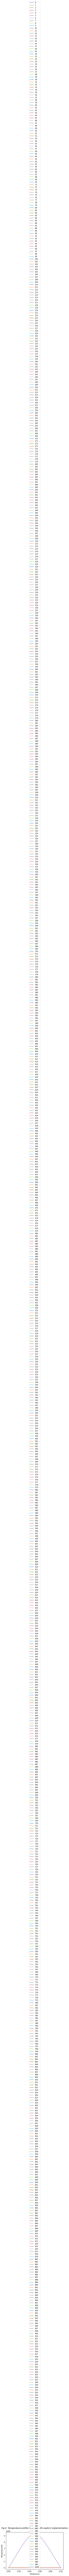

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
plt.title("Fig 8 :Temperature profile for wood with explicit implementation\n")
plt.show()

## Comment: 

Figure 7 and 8 shows the temparute profile of Wood for implicit and explicit Implementation of the source term respectively. Here, the problem converges for implicit implementation but it diverges for explicit implimentation of the source term.

# Conclusion: 

After Reviewing all 4 cases, we can see that the thermal conductivity (K) plays an important role in heat transfer. 
For higher thermal conductivity (Steel) the heat transfer rate did not depend on the linearization method.
On the other hand, for a lower thermal conductivity (Wood), the linearization coefficient impacts the numerical procedure. 
